In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from datasets import DatasetDict, Datasets
from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf
from sklearn.model_selection import train_test_split

c:\Users\Kalea\miniconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')
# df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED_2_KLASIFIKASI.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,cleaned_barang_bukti,summarized_dakwaan,extracted_pasal,terdakwa,total_pidana_penjara_bulan
0,0,0,0,6,1 buah sabit kecil dengan gagang dari kayu 1 b...,Terdakwa Gede Darmayasa didakwa telah melakuka...,['Pasal 362 KUHP jo. Pasal 65 Ayat (1) KUHP'],GEDE DARMAYASA,5.0
1,1,1,1,4,1 lembar nota pembelian perhiasan kalung emas ...,"Pada bulan Februari dan Maret 2024, terdakwa I...","['Pasal 372 jo. 64 Ayat (1) KUHP', 'Pasal 378 ...",IDA BAGUS MADE DARMA WIGUNA,24.0
2,0,0,2,6,1 buah Kotak/Box handphone merk OPPO type A53 ...,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",['Pasal 363 Ayat (1) ke-3 KUHP'],HANDRI JOHANAS,4.0
3,2,2,1,2,1 buah plastik klip bening yang berisi kristal...,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",['Pasal 112 Ayat (1) UU RI No. 35 Tahun 2009 t...,I GEDE ARIADI alias BERNAD,14.0
4,2,3,1,2,1 buah plastik klip bening yang berisi kristal...,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",['Pasal 112 Ayat (1) UU RI No. 35 Tahun 2009 t...,I GEDE ARIADI alias BERNAD,14.0
...,...,...,...,...,...,...,...,...,...
4577,2,373,134,2,1 buah kotak hitam di dalamnya ada 1 plastik k...,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",['Pasal 114 Ayat (1) UU RI No. 35 Tahun 2009 T...,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,72.0
4578,0,387,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",['Pasal 363 Ayat (1) ke-4 KUHP'],SUPRIADI BIN RATIM,16.0
4579,0,389,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",['Pasal 363 Ayat (1) ke-4 KUHP'],SUPRIADI BIN RATIM,16.0
4580,0,387,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",['Pasal 363 Ayat (1) ke-4 KUHP'],ANWAR RURI BIN SYARIFUDIN USMAN,16.0


In [4]:
df_filtered = df.drop(columns=['extracted_pasal'])

In [5]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4582 entries, 0 to 4581
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   klasifikasi_perkara_encoded  4582 non-null   int64  
 1   penuntut_umum_encoded        4582 non-null   int64  
 2   hakim_encoded                4582 non-null   int64  
 3   jumlah_saksi                 4582 non-null   int64  
 4   cleaned_barang_bukti         4582 non-null   object 
 5   summarized_dakwaan           4582 non-null   object 
 6   terdakwa                     4582 non-null   object 
 7   total_pidana_penjara_bulan   4582 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 286.5+ KB


### Split Data

In [6]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.7) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [7]:
train_df, test_df = stratified_split(df_filtered)

{(0, 0, 0): [0, 20], (0, 0, 2): [2], (0, 1, 0): [19], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 13, 0): [32], (0, 13, 3): [34], (0, 15, 4): [33], (0, 16, 0): [37], (0, 17, 0): [38], (0, 17, 14): [440, 504, 598, 612], (0, 17, 16): [425], (0, 17, 18): [477, 668], (0, 17, 19): [787, 788, 789, 790], (0, 17, 20): [435, 441, 521, 581, 611, 728, 749], (0, 17, 21): [642, 826], (0, 18, 0): [39], (0, 19, 0): [40, 41], (0, 20, 0): [42], (0, 22, 7): [46], (0, 26, 10): [52, 54], (0, 27, 10): [137, 153, 173], (0, 27, 11): [75, 104], (0, 27, 12): [174], (0, 27, 14): [119], (0, 28, 10): [100, 148], (0, 28, 11): [55], (0, 29, 10): [56], (0, 30, 10): [57, 94], (0, 30, 12): [90], (0, 31, 9): [58], (0, 31, 10): [106, 107, 109], (0, 31, 12): [96, 97], (0, 32, 10): [59, 60, 61], (0, 32, 12): [101, 102], (0, 33, 10): [175], (0, 33, 14): [145, 163, 164, 165, 167, 178], (0, 34, 10): [63, 91, 92, 93], (0, 34, 11): [6

C:\Users\Kalea\AppData\Local\Temp\ipykernel_36980\1615946564.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()


In [8]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3297
klasifikasi_perkara_encoded
0    1348
2    1280
3     300
4     188
1     181
Name: count, dtype: int64


In [9]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1285
klasifikasi_perkara_encoded
0    631
2    522
4     62
3     48
1     22
Name: count, dtype: int64


In [10]:
df_filtered

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,cleaned_barang_bukti,summarized_dakwaan,terdakwa,total_pidana_penjara_bulan
0,0,0,0,6,1 buah sabit kecil dengan gagang dari kayu 1 b...,Terdakwa Gede Darmayasa didakwa telah melakuka...,GEDE DARMAYASA,5.0
1,1,1,1,4,1 lembar nota pembelian perhiasan kalung emas ...,"Pada bulan Februari dan Maret 2024, terdakwa I...",IDA BAGUS MADE DARMA WIGUNA,24.0
2,0,0,2,6,1 buah Kotak/Box handphone merk OPPO type A53 ...,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",HANDRI JOHANAS,4.0
3,2,2,1,2,1 buah plastik klip bening yang berisi kristal...,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",I GEDE ARIADI alias BERNAD,14.0
4,2,3,1,2,1 buah plastik klip bening yang berisi kristal...,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",I GEDE ARIADI alias BERNAD,14.0
...,...,...,...,...,...,...,...,...
4577,2,373,134,2,1 buah kotak hitam di dalamnya ada 1 plastik k...,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,72.0
4578,0,387,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",SUPRIADI BIN RATIM,16.0
4579,0,389,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",SUPRIADI BIN RATIM,16.0
4580,0,387,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",ANWAR RURI BIN SYARIFUDIN USMAN,16.0


In [12]:
train_df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,cleaned_barang_bukti,summarized_dakwaan,terdakwa,total_pidana_penjara_bulan
0,0,0,0,6,1 buah sabit kecil dengan gagang dari kayu 1 b...,Terdakwa Gede Darmayasa didakwa telah melakuka...,GEDE DARMAYASA,5.0
2,0,0,2,6,1 buah Kotak/Box handphone merk OPPO type A53 ...,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",HANDRI JOHANAS,4.0
19,0,1,0,4,"- Uang tunai sebesar Rp. 10.000.000,00(sepuluh...","Pada hari Rabu, 25 Oktober 2023 sekitar pukul ...",I NYOMAN BUDIAWAN Als. SUMAWAN,14.0
35,0,1,4,3,1 unit sepeda motor yang sudah dimodifikasi (c...,"Pada Minggu, 11 Desember 2022 sekitar pukul 00...",RIFQI ABDURAHMAN,8.0
5,0,4,1,4,1 unit sepeda motor merk Honda Scoopy warna me...,"Pada hari Selasa, 26 Maret 2024 sekitar pukul ...",R. Sabirin,14.0
...,...,...,...,...,...,...,...,...
4351,4,398,135,2,"Uang tunai sebesar Rp 2.450.000,- (dua juta em...","Pada hari Minggu, 09 Juli 2023, sekitar pukul ...",JOYO CIPTO alias TOTO Bin SALIMIN,8.0
4346,4,398,135,2,"Uang tunai sebesar Rp 2.450.000,- (dua juta em...","Pada Minggu, 09 Juli 2023, sekitar pukul 00.15...",FERI Bin TAMIN,8.0
4345,4,398,135,2,"Uang tunai sebesar Rp 2.450.000,- (dua juta em...","Pada Minggu, 09 Juli 2023, sekitar pukul 00.15...",AHMAD JUMADI alias MADI Bin SUBUR,8.0
4348,4,398,135,2,"Uang tunai sebesar Rp 2.450.000,- (dua juta em...","Pada hari Minggu, 09 Juli 2023, sekitar pukul ...",SARONI Bin RASKI,8.0


## Model

### Model Preprocessing

In [13]:
train_df['concat_text'] = train_df[['summarized_dakwaan', 'terdakwa']].apply(lambda x: ' '.join(x), axis=1)
test_df['concat_text'] = test_df[['summarized_dakwaan', 'terdakwa']].apply(lambda x: ' '.join(x), axis=1)

In [14]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Tokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

def tokenize_function(text):
    return tokenizer(text['concat_text'], padding='max_length', truncation=True, max_length=512)

train_encodings = tokenizer(train_df['concat_text'].tolist(), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(test_df['concat_text'].tolist(), padding=True, truncation=True, max_length=512)

print(tokenizer.truncation_side)

right


### Convert to Tensor

In [16]:
train_inputs = tf.constant(train_encodings['input_ids'])
train_attention_masks = tf.constant(train_encodings['attention_mask'])

test_inputs = tf.constant(test_encodings['input_ids'])
test_attention_masks = tf.constant(test_encodings['attention_mask'])

train_numerical = tf.constant(train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi']].values, dtype=tf.float32)
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi']].values, dtype=tf.float32)

train_labels = tf.constant(y_train.values, dtype=tf.float32)
test_labels = tf.constant(y_test.values, dtype=tf.float32)

### Create Dataset from Tensor

In [17]:
import tensorflow as tf

def create_bert_regressor_dataset(input_ids, attention_mask, numerical_features, labels):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'numerical_feature': numerical_features
    }, labels))
    return dataset

train_dataset = create_bert_regressor_dataset(train_inputs, train_attention_masks, train_numerical, train_labels)
test_dataset = create_bert_regressor_dataset(test_inputs, test_attention_masks, test_numerical, test_labels)

train_dataset = train_dataset.batch(2)
test_dataset = test_dataset.batch(2)


### Model Architecture

In [18]:
class BERTRegressor(tf.keras.Model):
    def __init__(self):
        super(BERTRegressor, self).__init__()
        self.bert = TFBertModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True)

        for layer in self.bert.layers:
            layer.trainable = False
            
        self.regressor = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        numerical_features = inputs['numerical_feature']

        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        combined_output = tf.concat([pooled_output, numerical_features], axis=1)

        return self.regressor(combined_output)

model = BERTRegressor()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

### Compile Model

In [19]:
model.compile(optimizer='adam',
              loss='mean_squared_error', metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError()])

### Train Model

In [20]:
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
1649/1649 [==============================] - 124s 70ms/step - loss: 460.4146 - mean_absolute_error: 14.0194 - root_mean_squared_error: 21.4573 - val_loss: 1996.1793 - val_mean_absolute_error: 26.7428 - val_root_mean_squared_error: 44.6786
Epoch 2/5
1649/1649 [==============================] - 114s 69ms/step - loss: 449.8925 - mean_absolute_error: 13.7807 - root_mean_squared_error: 21.2107 - val_loss: 1932.0515 - val_mean_absolute_error: 26.3348 - val_root_mean_squared_error: 43.9551
Epoch 3/5
1649/1649 [==============================] - 113s 68ms/step - loss: 443.2048 - mean_absolute_error: 13.7019 - root_mean_squared_error: 21.0524 - val_loss: 1889.1444 - val_mean_absolute_error: 25.9604 - val_root_mean_squared_error: 43.4643
Epoch 4/5
1649/1649 [==============================] - 114s 69ms/step - loss: 432.3063 - mean_absolute_error: 13.5638 - root_mean_squared_error: 20.7920 - val_loss: 1852.5013 - val_mean_absolute_error: 25.6265 - val_root_mean_squared_error: 43.0407
Epoc

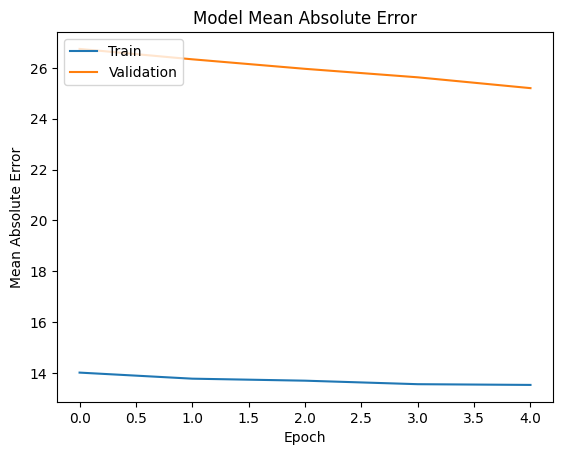

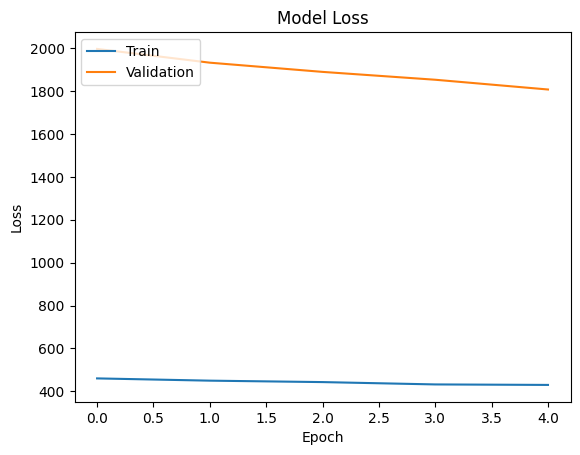

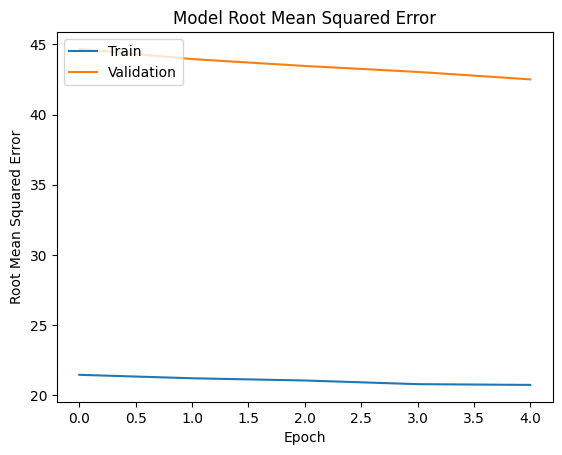

In [21]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Inference

In [24]:
klasifikasi_perkara_encoded = 2
penuntut_umum_encoded = 9
hakim_encoded = 3
jumlah_saksi_inference = 3
# maks_lama_penjara_berdasarkan_pasal = 84

inference_text = "1 (satu) unit sepeda motor yang sudah dimodifikasi (cetul) tanpa terpasang nomor registrasi / nomor polisi dan tidak dapat terdapat nomor rangka dan nomor mesin kendaraan Dikembalikan kepada I Gede Wiraguna 1 (satu) unit sepeda motor merek Kawasaki tipe LX 150 C, warna hitam kombinasi kuning, tahun pembuatan 2010, tanpa terpasang nomor registrasi / nomor polisi, Noka MH4LX150CAKP15705, Nosin LX150CEP19759 1 (satu) lembar SNTK sepeda motor merek Kawasaki tipe LX 150 C, warna hijau, tahun pembuatan 2010, nomor registrasi / nomor polisi DK 8164 IQ, Noka MH4LX150CAKP15705, Nosin LX150CEP19759, a.n. Chrisnawati, alamat Jl. Surabaya D, 6/20 Puri Gading, Jimbaran, Kuta Badung dan 1 (satu) buah buku BPKB, No H-0 2625520, DK 8164 IQ, merek Kawasaki tipe LX 150 C, Noka MH4LX150CAKP15705, Nosin LX150CEP19759, a.n. Chrisnawati, alamat Jl. Surabaya D, 6/20 Puri Gading, Jimbaran, Kuta Badung Dikembalikan kepada I Wayan Eva Kusuma Putra 6. Membebankan kepada Para Terdakwa membayar biaya perkara masing-masing sejumlah Rp5.000,00 (lima ribu rupiah) Terdakwa I, Rifqi Abdurahman, dan Terdakwa II, Gunawan, didakwa melakukan pencurian sepeda motor Kawasaki KLX 150 C di Jalan Raya Kayuambua, Bangli, pada 11 Desember 2022, sekitar pukul 00.30 WITA. Berawal dari permintaan Gunawan untuk mencarikan motor KLX, mereka berdua berangkat dari Denpasar ke Kintamani. Di lokasi kejadian, mereka melihat motor KLX tanpa kunci kontak. Rifqi mengambil motor tersebut dengan mendorongnya, sementara Gunawan mengawasi.  Karena Rifqi tidak bisa menyalakan motor, Gunawan membantu mendorongnya. Namun, motor mereka mengalami kerusakan, dan Rifqi melanjutkan mendorong motor curian sendirian. Saat mendorong, Rifqi bertemu saksi-saksi yang curiga dan menghubungi pemilik motor. Rifqi berhasil menyalakan motor, tetapi kehabisan bensin. Ia melanjutkan mendorong ke SPBU Sekardadi, di mana ia tertidur dan ditangkap polisi.  Gunawan ditangkap di Desa Dumilih. Motor curian dan motor yang digunakan para terdakwa disita. Korban, I Wayan Eva Kusuma Putra, mengalami kerugian Rp16.000.000. Para terdakwa didakwa melanggar Pasal 363 Ayat (1) Ke 4 KUHP sebagai dakwaan primair dan Pasal 362 KUHP sebagai dakwaan subsidair. RIFQI ABDURAHMAN"
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference]], dtype=tf.float32)
inputs = tokenizer(inference_text, padding=True, truncation=True, return_tensors='tf', max_length=512)

input_dict = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'numerical_feature': inference_numerical_tensor
}

In [25]:
predictions = model(input_dict)
predictions_np = predictions.numpy()

print(predictions_np)


[[19.460064]]


In [22]:
model.save('../Model/BERT_NO_PASAL_NO_BARANG_BUKTI')

INFO:tensorflow:Assets written to: ../Model/BERT_NO_PASAL_NO_BARANG_BUKTI\assets


INFO:tensorflow:Assets written to: ../Model/BERT_NO_PASAL_NO_BARANG_BUKTI\assets


## Saved Model Inference

In [32]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

class BERTRegressor(tf.keras.Model):
    def __init__(self):
        super(BERTRegressor, self).__init__()
        self.bert = TFBertModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True)
        for layer in self.bert.layers:
            layer.trainable = False
        self.regressor = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        numerical_features = inputs['numerical_feature']

        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined_output = tf.concat([pooled_output, numerical_features], axis=1)

        return self.regressor(combined_output)

loaded_model = tf.keras.models.load_model('../Model/dummy_run_BERT_2', custom_objects={'BERTRegressor': BERTRegressor})

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [33]:
klasifikasi_perkara_encoded = 2
penuntut_umum_encoded = 9
hakim_encoded = 3
jumlah_saksi_inference = 3
maks_lama_penjara_berdasarkan_pasal = 84

inference_text = "1 (satu) unit sepeda motor yang sudah dimodifikasi (cetul) tanpa terpasang nomor registrasi / nomor polisi dan tidak dapat terdapat nomor rangka dan nomor mesin kendaraan Dikembalikan kepada I Gede Wiraguna 1 (satu) unit sepeda motor merek Kawasaki tipe LX 150 C, warna hitam kombinasi kuning, tahun pembuatan 2010, tanpa terpasang nomor registrasi / nomor polisi, Noka MH4LX150CAKP15705, Nosin LX150CEP19759 1 (satu) lembar SNTK sepeda motor merek Kawasaki tipe LX 150 C, warna hijau, tahun pembuatan 2010, nomor registrasi / nomor polisi DK 8164 IQ, Noka MH4LX150CAKP15705, Nosin LX150CEP19759, a.n. Chrisnawati, alamat Jl. Surabaya D, 6/20 Puri Gading, Jimbaran, Kuta Badung dan 1 (satu) buah buku BPKB, No H-0 2625520, DK 8164 IQ, merek Kawasaki tipe LX 150 C, Noka MH4LX150CAKP15705, Nosin LX150CEP19759, a.n. Chrisnawati, alamat Jl. Surabaya D, 6/20 Puri Gading, Jimbaran, Kuta Badung Dikembalikan kepada I Wayan Eva Kusuma Putra 6. Membebankan kepada Para Terdakwa membayar biaya perkara masing-masing sejumlah Rp5.000,00 (lima ribu rupiah) Terdakwa I, Rifqi Abdurahman, dan Terdakwa II, Gunawan, didakwa melakukan pencurian sepeda motor Kawasaki KLX 150 C di Jalan Raya Kayuambua, Bangli, pada 11 Desember 2022, sekitar pukul 00.30 WITA. Berawal dari permintaan Gunawan untuk mencarikan motor KLX, mereka berdua berangkat dari Denpasar ke Kintamani. Di lokasi kejadian, mereka melihat motor KLX tanpa kunci kontak. Rifqi mengambil motor tersebut dengan mendorongnya, sementara Gunawan mengawasi.  Karena Rifqi tidak bisa menyalakan motor, Gunawan membantu mendorongnya. Namun, motor mereka mengalami kerusakan, dan Rifqi melanjutkan mendorong motor curian sendirian. Saat mendorong, Rifqi bertemu saksi-saksi yang curiga dan menghubungi pemilik motor. Rifqi berhasil menyalakan motor, tetapi kehabisan bensin. Ia melanjutkan mendorong ke SPBU Sekardadi, di mana ia tertidur dan ditangkap polisi.  Gunawan ditangkap di Desa Dumilih. Motor curian dan motor yang digunakan para terdakwa disita. Korban, I Wayan Eva Kusuma Putra, mengalami kerugian Rp16.000.000. Para terdakwa didakwa melanggar Pasal 363 Ayat (1) Ke 4 KUHP sebagai dakwaan primair dan Pasal 362 KUHP sebagai dakwaan subsidair. RIFQI ABDURAHMAN"
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference, maks_lama_penjara_berdasarkan_pasal]], dtype=tf.float32)
inputs = tokenizer(inference_text, padding=True, truncation=True, return_tensors='tf', max_length=512)

input_dict = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'numerical_feature': inference_numerical_tensor
}

In [34]:
predictions = loaded_model(input_dict)
predictions_np = predictions.numpy()

print(predictions)
print(predictions_np)
print(predictions_np[0][0])


tf.Tensor([[15.147672]], shape=(1, 1), dtype=float32)
[[15.147672]]
15.147672
